# Model Development and Apparent Validation

In [ ]:
source("notebooks/initialize-data-analysis.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 5669 Columns: 113
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): patient_ID, site, dept, LZD_route
dbl  (20): patient_age, patient_weight, charlson, baseline_CLCR, baseline_WB...
lgl  (85): patient_sex, dept_ICU, dept_ER, dept_other, invasive_ETI, invasiv...
date  (4): baseline_date, LZD_start, LZD_end, test_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column t

# Penalized Likelihood Methods

## Backwards Stepwise Logistic Regression

In [ ]:
# library(StepReg)
# run_stepwise_logit <- function(data, formula) {
#   stepwiseLogit(
#     formula,
#     data = data,
#     include = NULL,
#     selection = "backward",
#     select = "AIC"
#   )
# }

# stepwise_model <- data_patient_complete |>
#   select(all_of(predictor_list), flag_ADR_TP_ID) |>
#   run_stepwise_logit(
#     formula = flag_ADR_TP_ID ~ .
#   )

# stepwise_model |> summary()

In [ ]:
run_step_AIC <- function(data, formula) {
  MASS::stepAIC(
    glm(
      formula = formula,
      data = data
    ),
    direction = "backward",
    trace = FALSE
  )
}

stepwise_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_step_AIC(
    formula = flag_ADR_TP_ID ~ .
  )

stepwise_model$coefficients |> length()

[1] 18

Results: Stepwise algorithm selected 18 predictors.

## LASSO Variable Selection

In [ ]:
library(glmnet)

Loading required package: Matrix


Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack

Loaded glmnet 4.1-8

[1] 24

Results: LASSO algorithm selected 23-25 predictors. Comment: Penalized likelihood methods have comparable predictive performance to Bayesian methods \[citation needed\], but select many more predictors.

# Bayesian Model Selection

                         P(B != 0 | Y)       model 1   model 2       model 3
Intercept                  1.000000000    1.00000000    1.0000    1.00000000
patient_age                0.755044266    1.00000000    1.0000    0.00000000
patient_sexTRUE            0.005010745    0.00000000    0.0000    0.00000000
LZD_dose_per_weight        0.004866145    0.00000000    0.0000    0.00000000
baseline_CLCR              0.292274912    0.00000000    0.0000    1.00000000
dept_ERTRUE                0.004663487    0.00000000    0.0000    0.00000000
dept_ICUTRUE               0.016263174    0.00000000    0.0000    0.00000000
baseline_HGB               0.130682869    0.00000000    0.0000    0.00000000
baseline_WBC               0.006076483    0.00000000    0.0000    0.00000000
baseline_PLT               1.000000000    1.00000000    1.0000    1.00000000
LZD_duration               0.999834570    1.00000000    1.0000    1.00000000
invasive_ETITRUE           0.162451919    0.00000000    0.0000    0.00000000

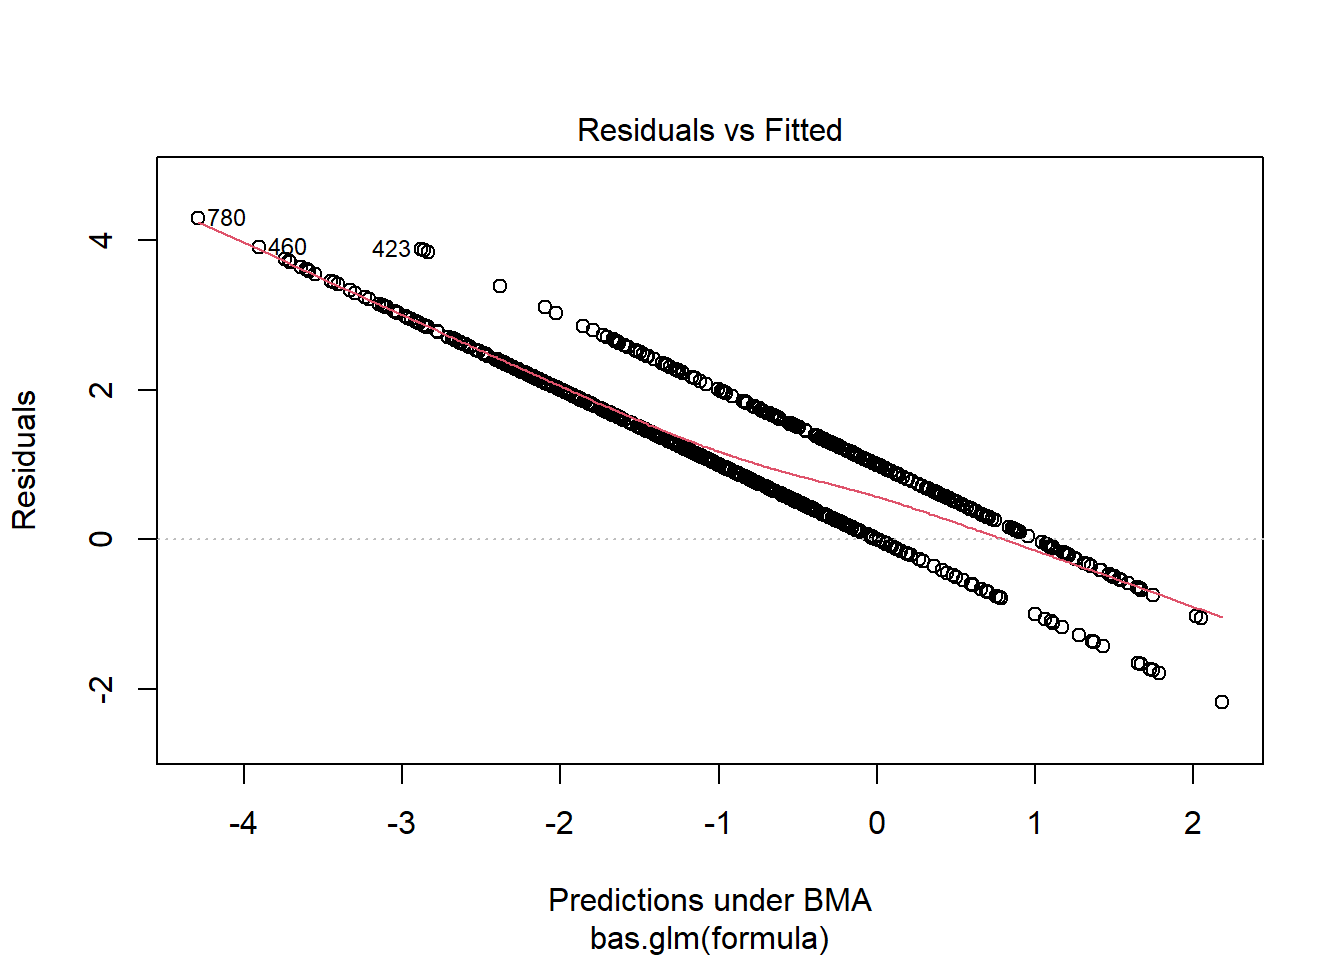

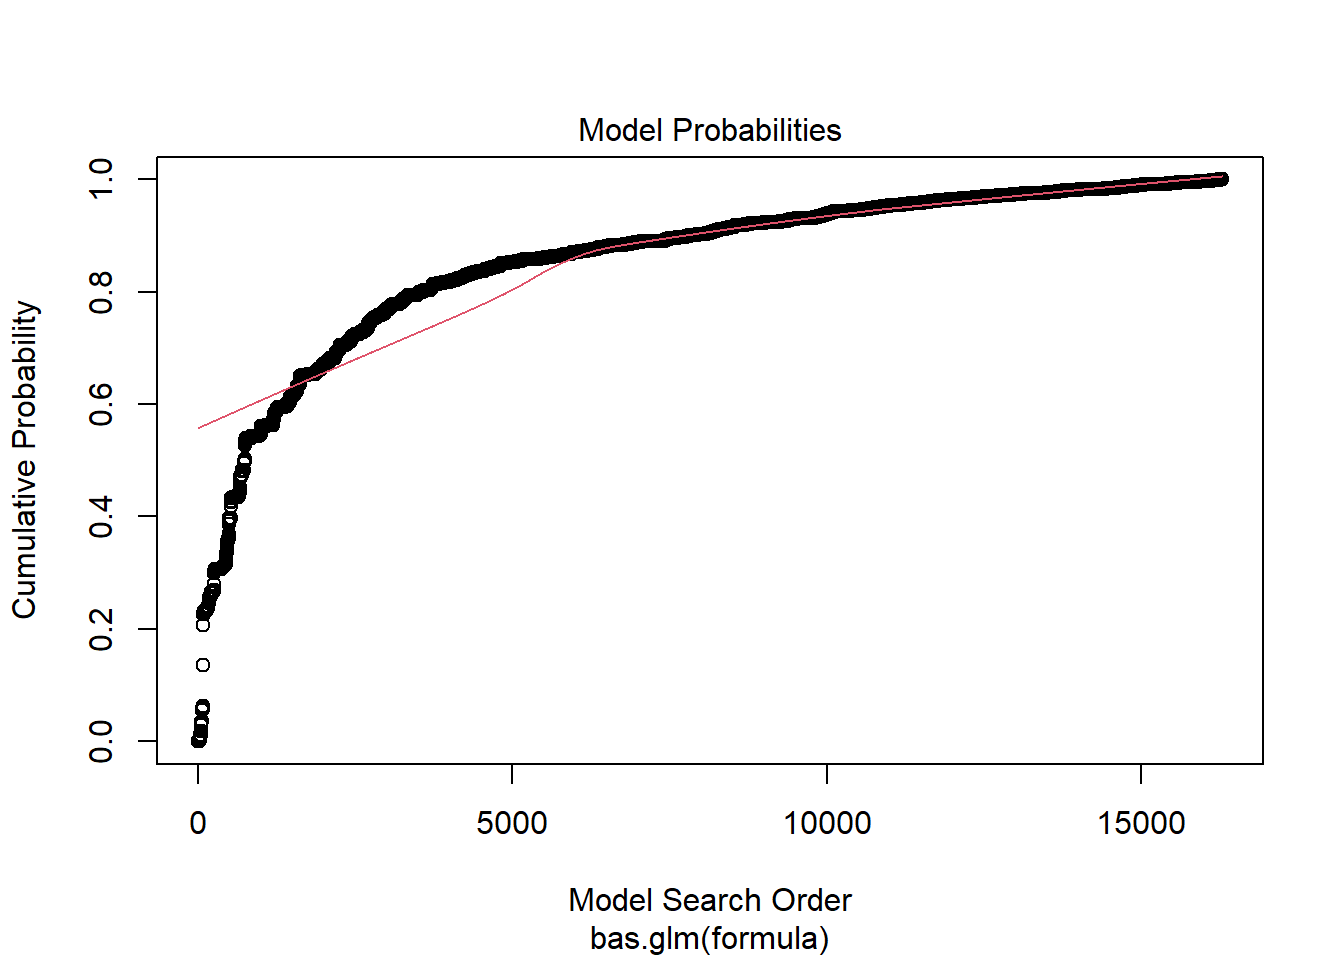

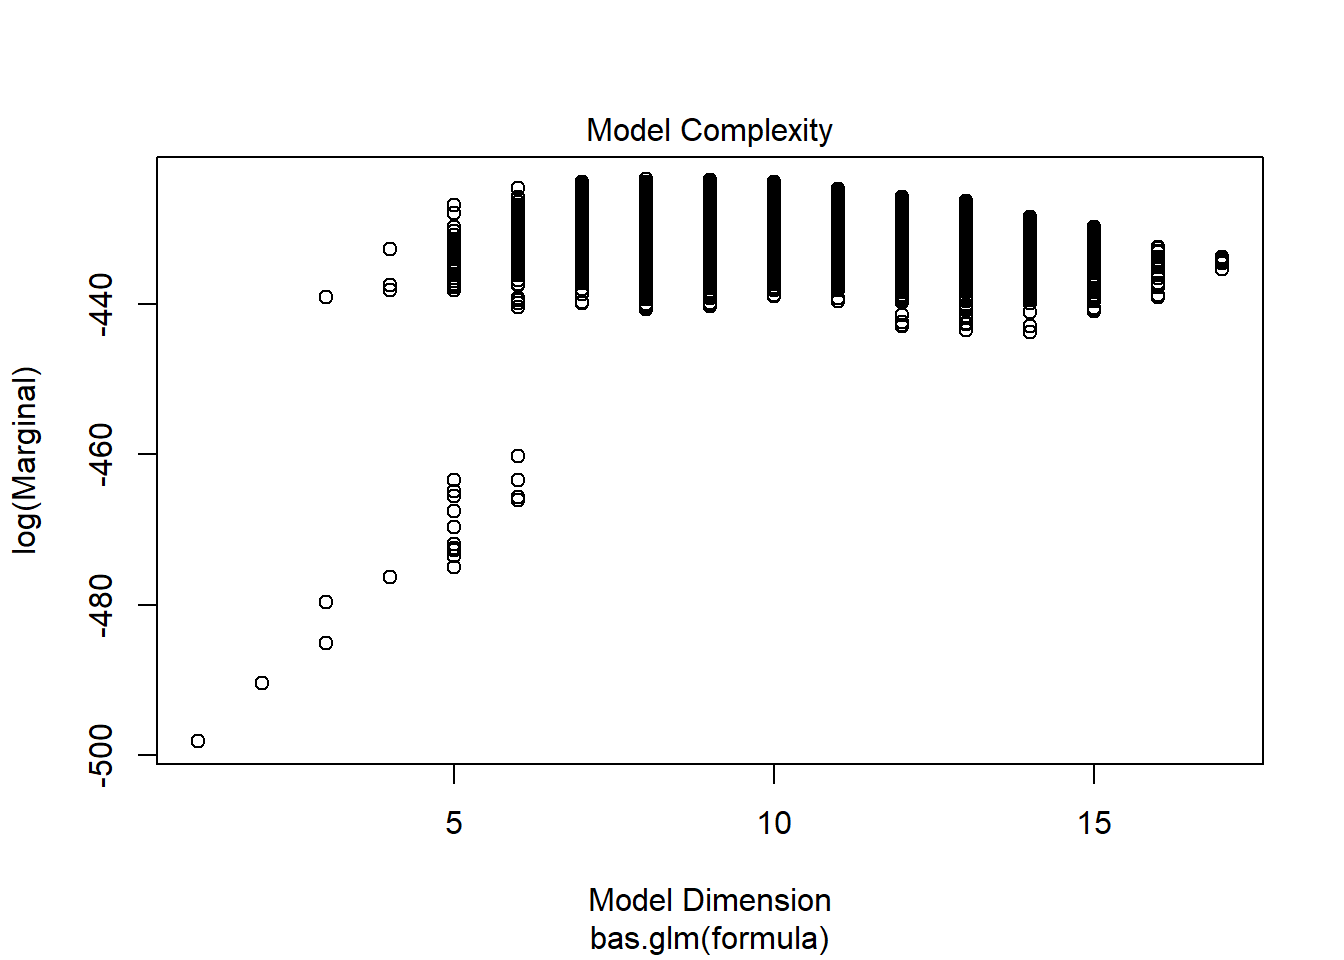

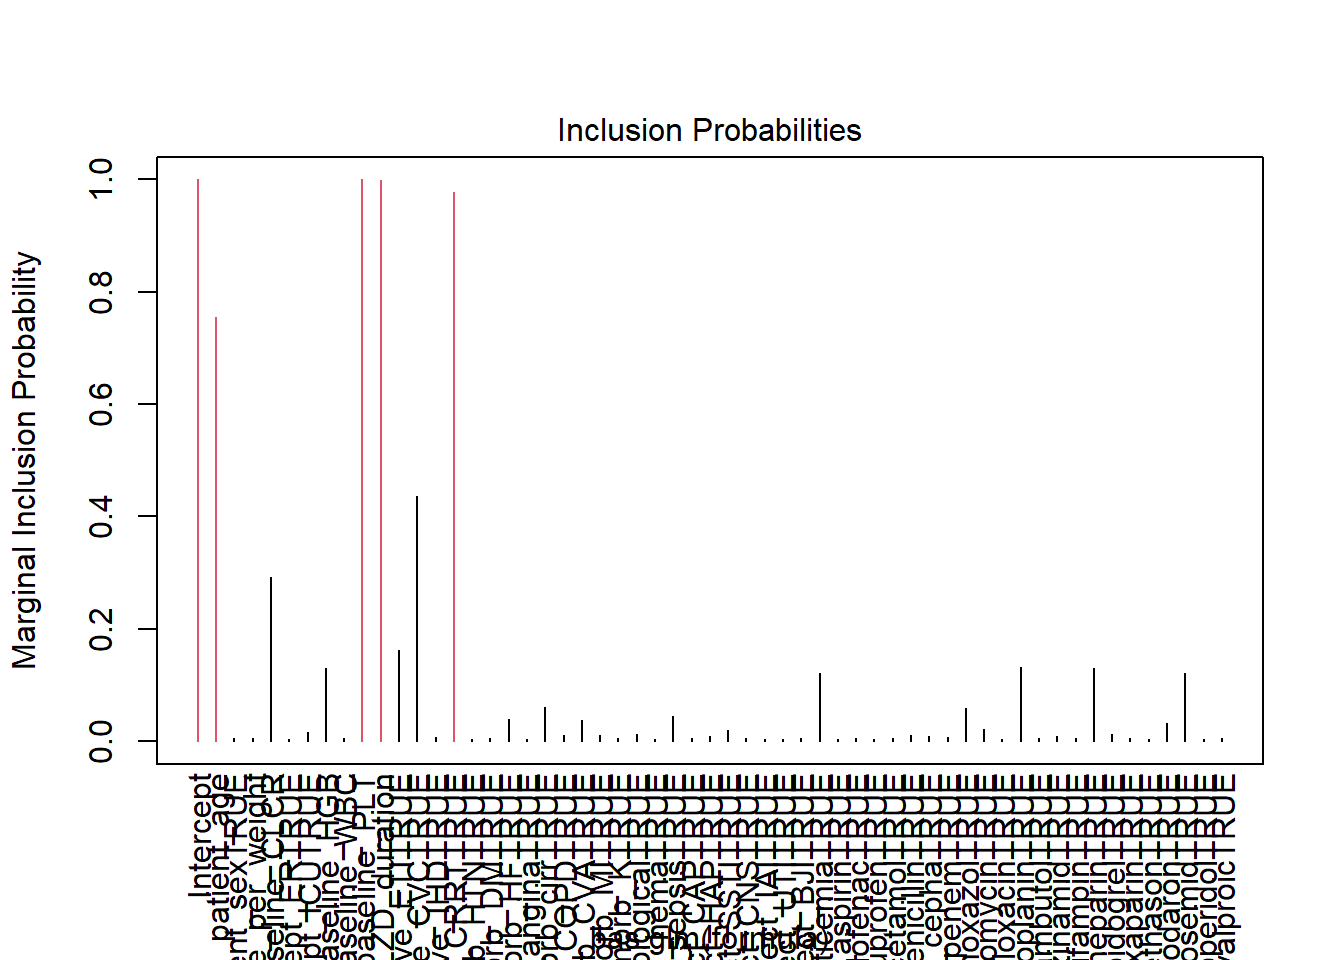

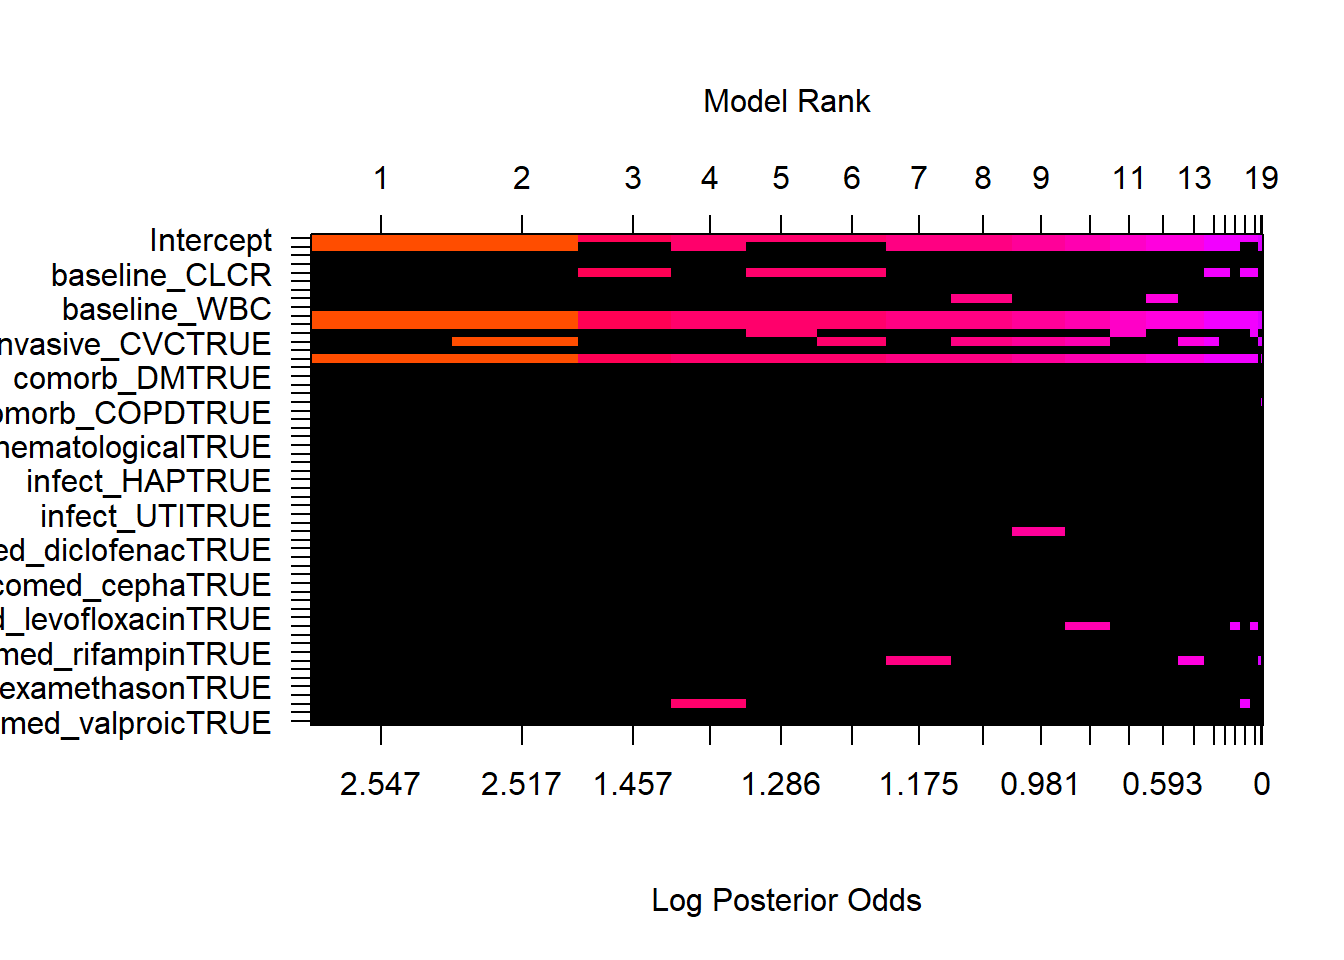

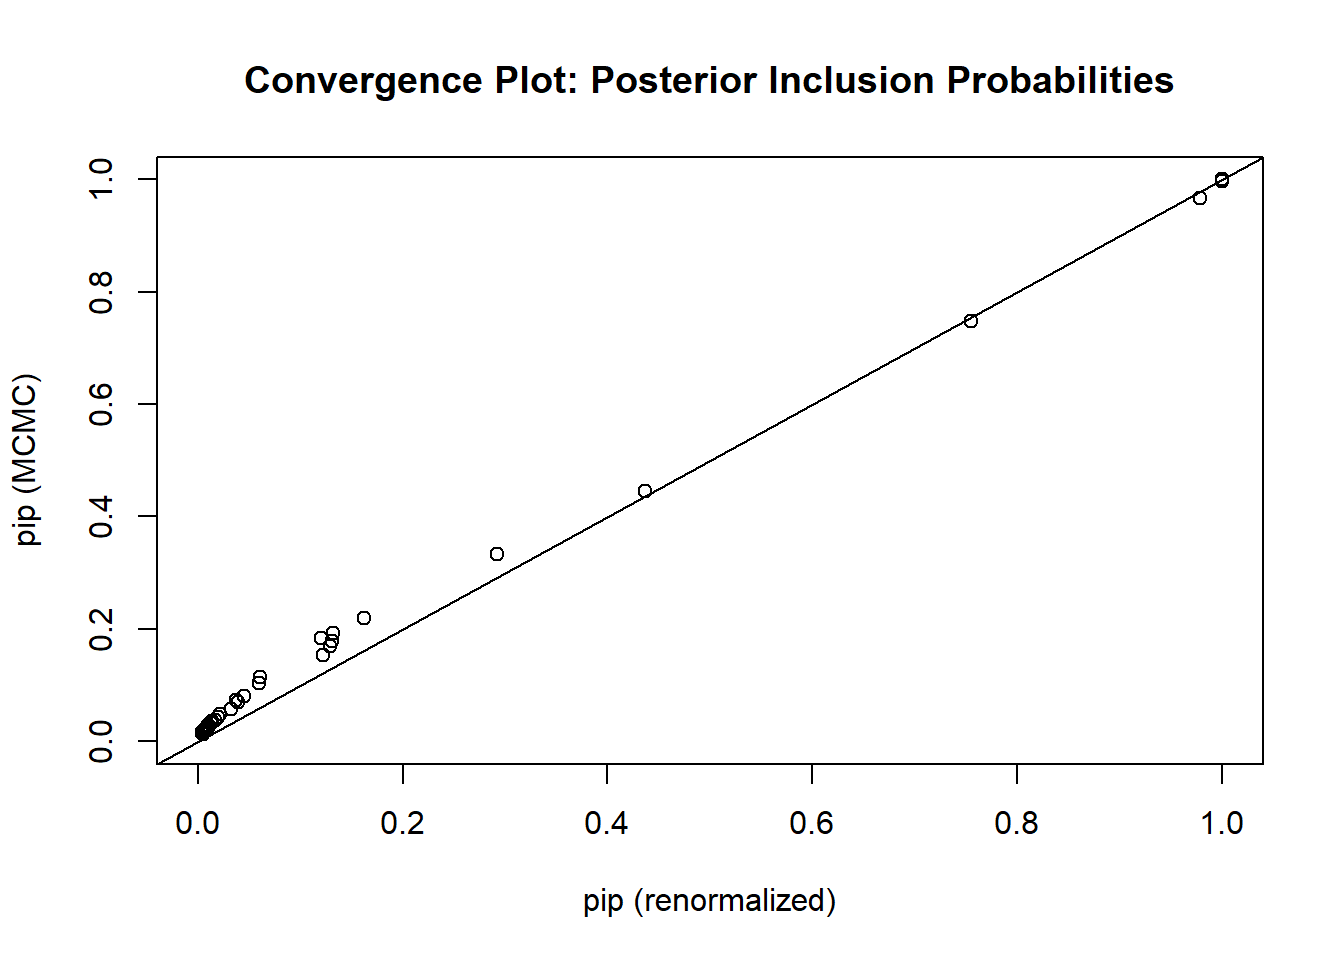

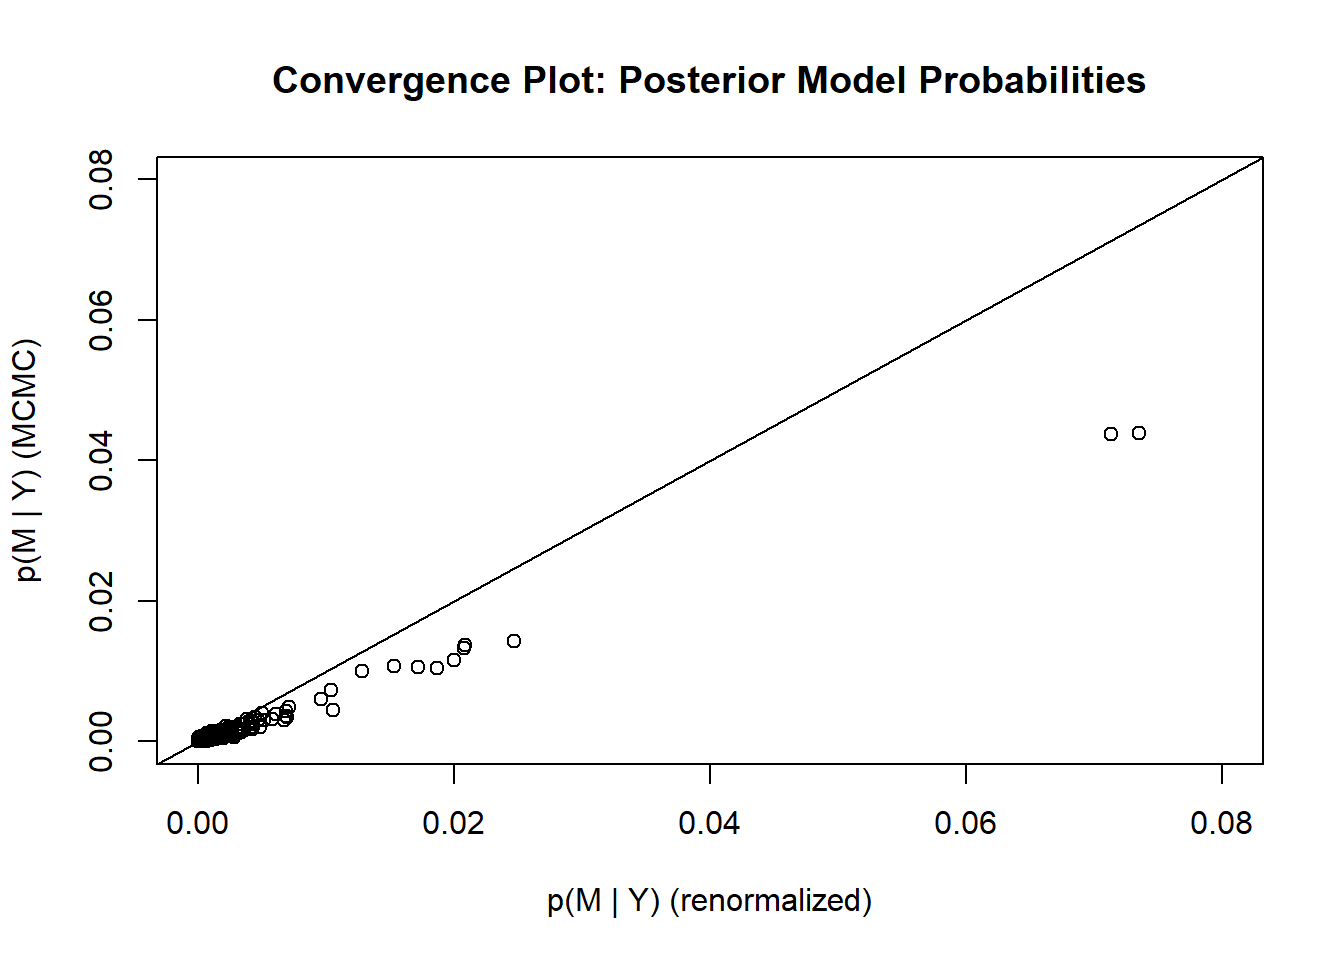

In [ ]:
multi_model <- data_patient_complete |>
  select(all_of(predictor_list), flag_ADR_TP_ID) |>
  run_bas_glm(
    formula = flag_ADR_TP_ID ~ .
  )

summary(multi_model)

In [ ]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.3.0
✔ recipes      1.0.9     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ Matrix::expand()  masks tidyr::expand()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ Matrix::pack()    masks tidyr::pack()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
✖ Matrix::unpack()  masks tidyr::unpack()
✖ recipes::update() masks Matrix::update(), stats::update()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

# Check Model Assumptions

## Linearity

Visual check of linearity assumption using partial-residual plots (component+residual plots). Blue dashed line: linear fit of the partial residuals. Red line: smoothed conditional mean The lines should be close together and the red line should be linear.

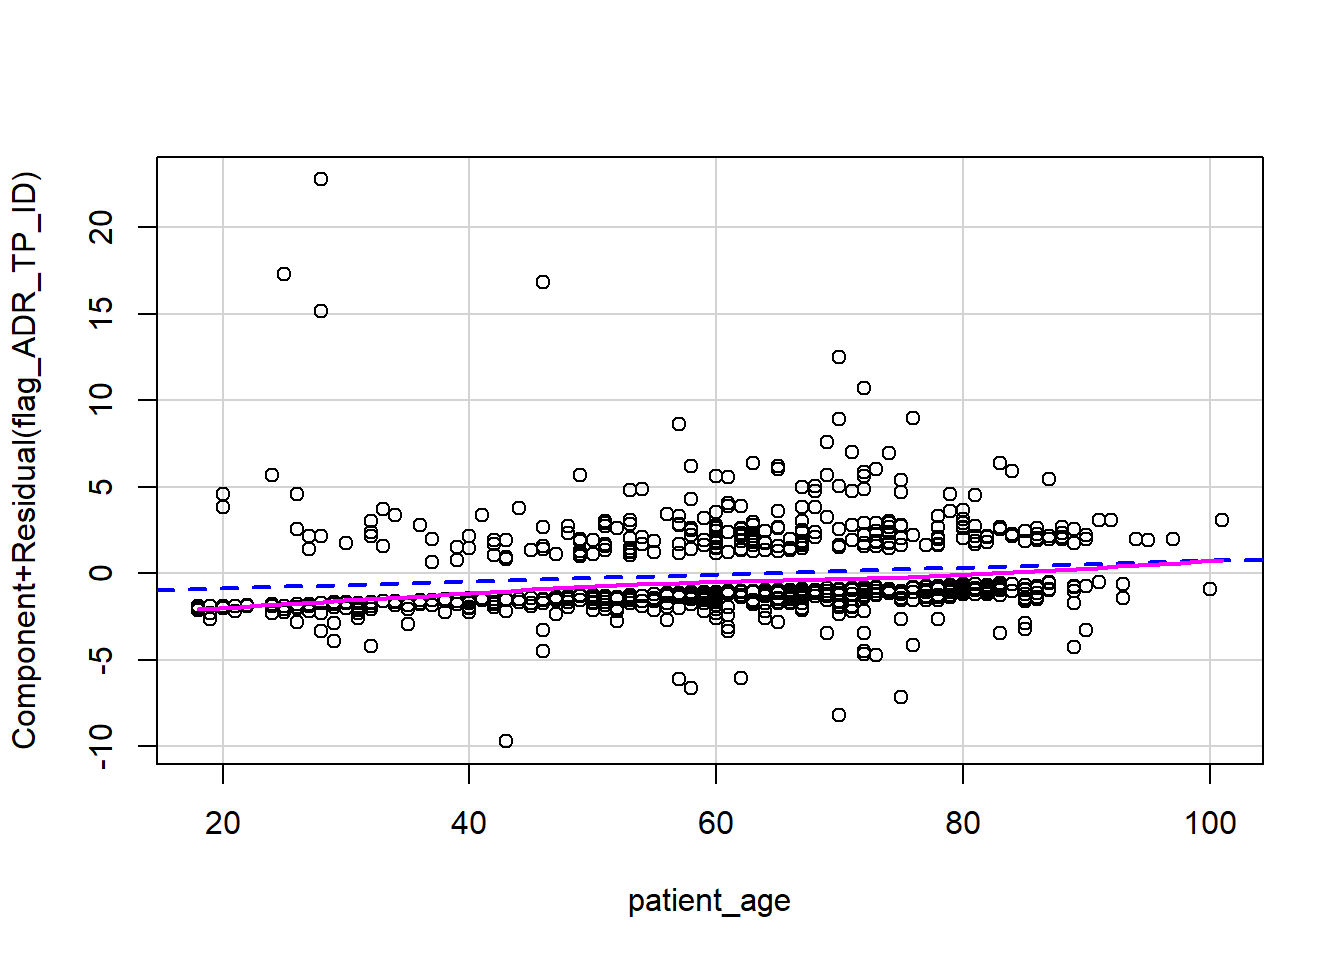

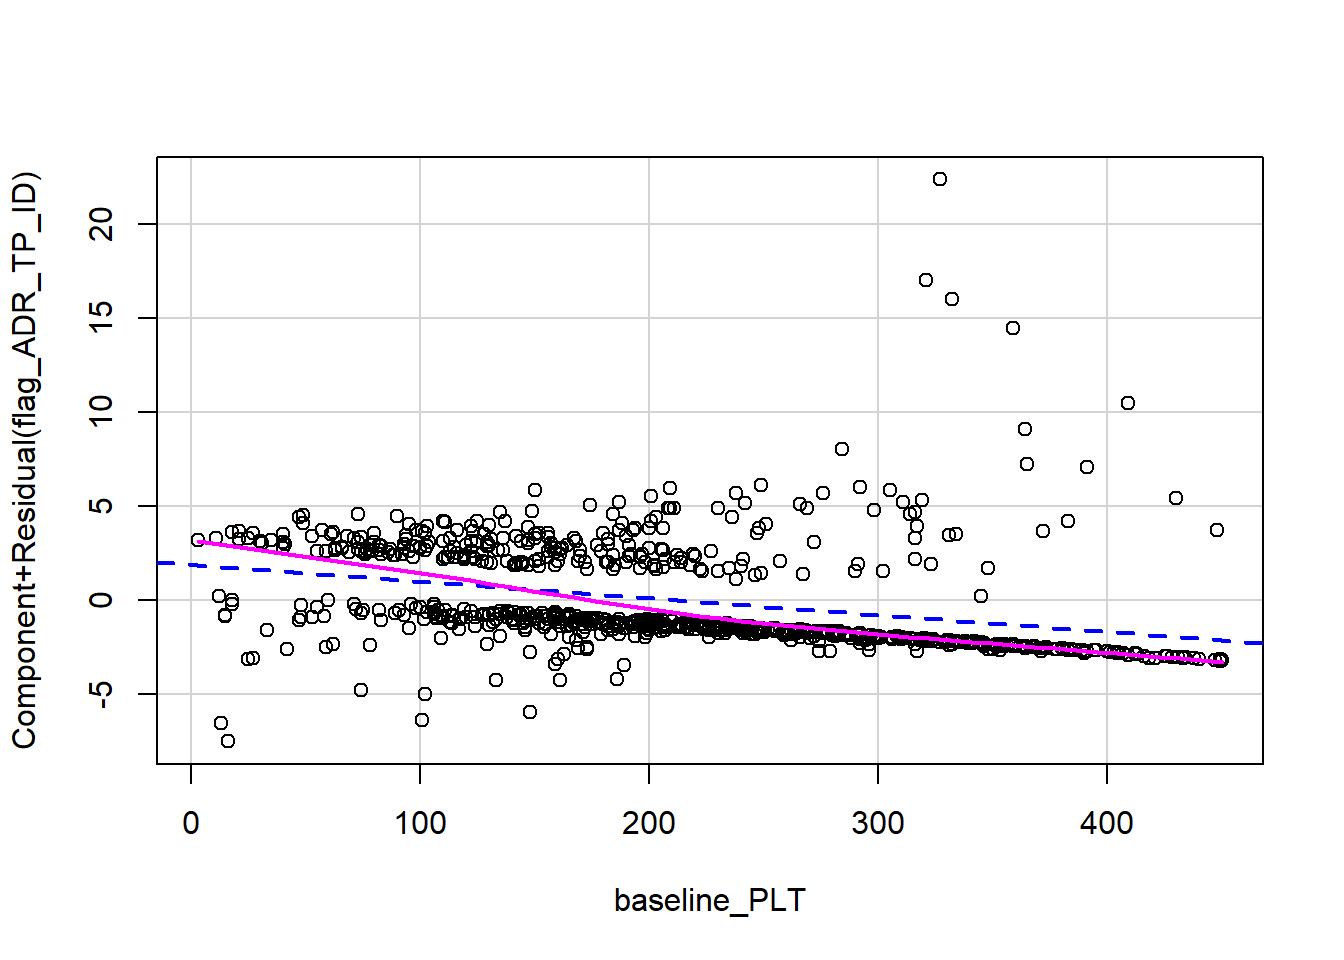

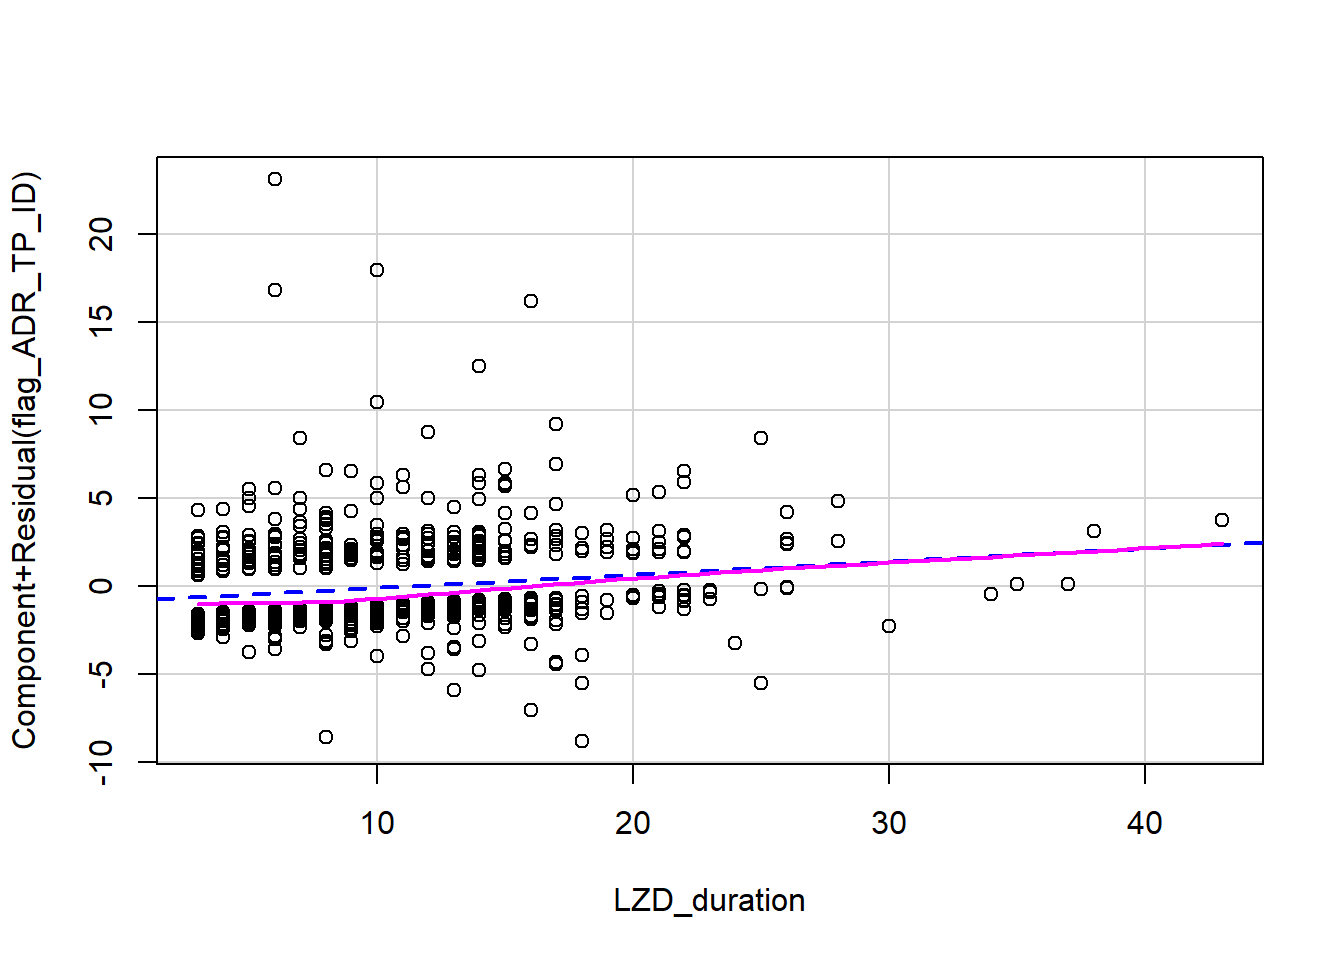

In [ ]:
car::crPlot(model_full$fit, variable = "patient_age")

Result: No obvious non-linearity in the partial-residual plots.

## No Multicollinearity

VIFs from the coefficient estimates should be less than 5 and as close to 1 as possible.

In [ ]:
car::vif(model_full$fit)

  patient_age  baseline_PLT  LZD_duration invasive_CRRT 
     1.028328      1.089070      1.087972      1.002530 

Result: VIFs are all less than 5 and close to 1.

## No Outlier Effects

Visual check from influence plot. Individual observations should not have too much influence on the model.

Influence plot: - x-axis: Extreme values (Hat-values) - y-axis: Leverage (Studentized residuals) - Size of points: Cook’s distance

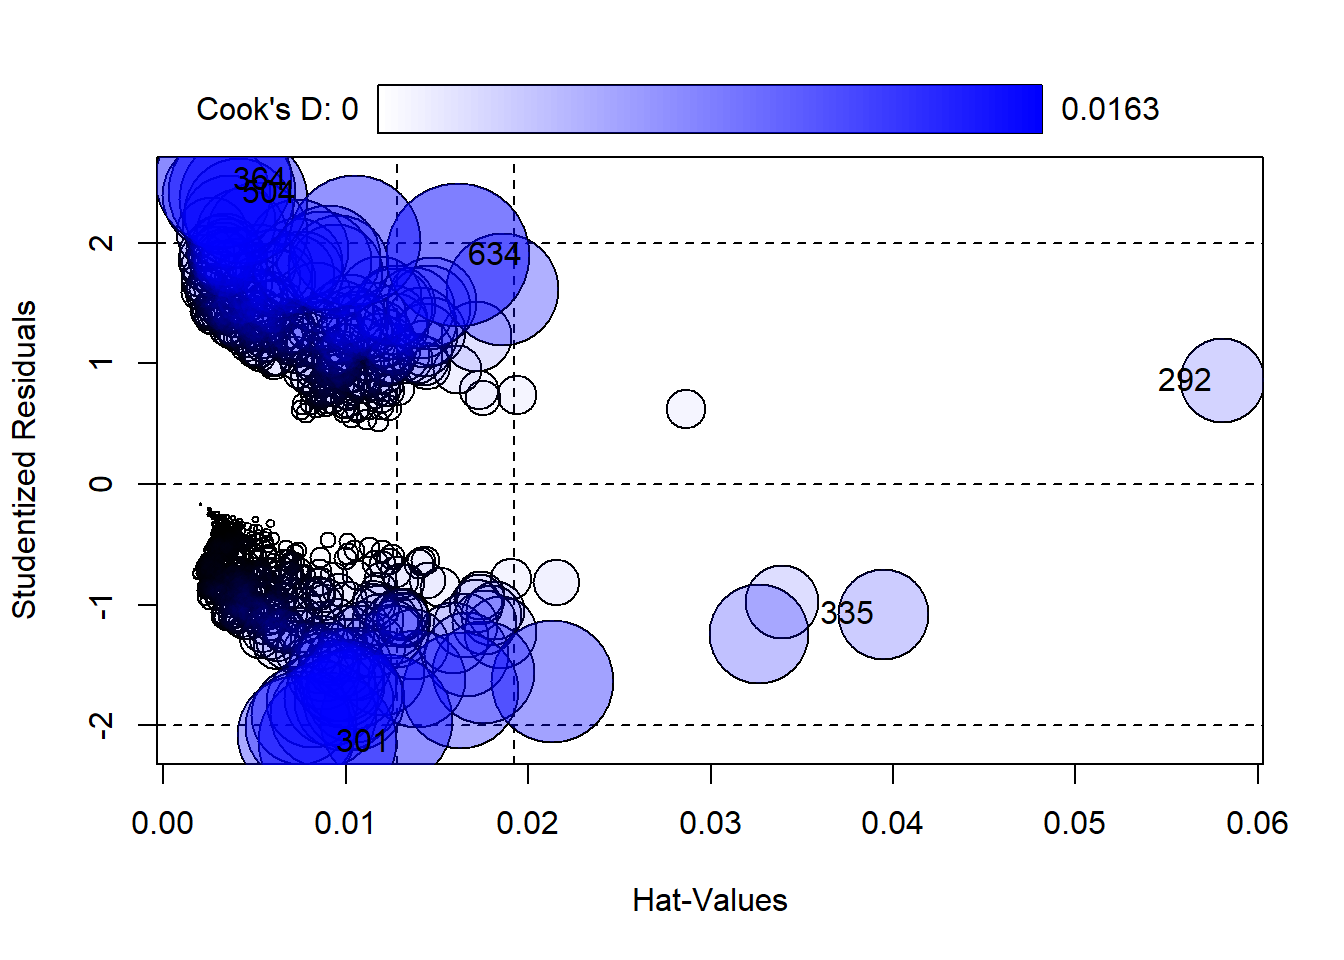

       StudRes         Hat       CookD
292  0.8611717 0.058037287 0.005623179
301 -2.1323174 0.008957174 0.015234647
335 -1.0748001 0.039483700 0.006456634
364  2.5264097 0.003270231 0.014774994
504  2.4184715 0.003775986 0.012961219
634  1.9030701 0.016178072 0.016297578

In [ ]:
car::influencePlot(model_full$fit)

Result: Influential observations identified. TODO: Investigate observations 292, 301, 335, 364, 504, 634.

In [ ]:
library(CalibrationCurves)

Loading required package: rms

Loading required package: Hmisc


Attaching package: 'Hmisc'

The following object is masked from 'package:parsnip':

    translate

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

In [ ]:
save(model_full, file = "data/model-performance/model-full.rda")